In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import os, sys
from pathlib import Path
import dask
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# version of weights to use
v=3

# Expected errors

In [3]:
datasets = []

for simulation in range(1,3,1):

    ds = pd.read_csv(
        f"/shares/gcp/social/rff/fivebeans{v}/emulate-fivebean-{simulation}.csv",
        skiprows=9,
    )

    for i, name in enumerate(["iso", "year"]):
        ds[name] = ds["name"].str.split(":", expand=True)[i]

    ds = ds.loc[ds.param == "error"]

    ds["simulation"] = simulation

    ds["year"] = ds.year.astype(int)

    ds = ds.set_index(["iso", "simulation", "year"]).to_xarray()["value"]

    datasets.append(ds)

expected_errors = xr.concat(datasets, dim="simulation").rename('expected').to_dataset()

# Actual errors

In [5]:
# get emulated log(gdppc)

weights = xr.open_zarr(
    f"/shares/gcp/integration/rff/damage_function_weights/damage_function_weights{v}.zarr",
    consolidated=True
).value

socioec = xr.open_zarr(
    "/shares/gcp/integration/float32/dscim_input_data/econvars/zarrs/integration-econ-bc39.zarr",
    consolidated=True
)

socioec['iso'] = socioec.region.str[:3]
socioec = socioec.groupby('iso').sum('region')
log_gdppc = np.log(socioec.gdp / socioec.pop)

emu = (log_gdppc * weights).sum(['ssp', 'model'])

# get true log(gdppc)

true = xr.open_dataset("/shares/gcp/integration/rff/socioeconomics/rff_country_socioeconomics.nc4")
true = np.log(true.gdp/true.pop).rename({'Country' : 'iso'})

# calculate absolute difference between emulated and true log(gdppc)
actual_errors = np.abs(emu - true).rename('actual').to_dataset()

# Absolute difference between actual and expected errors

In [6]:
combined = xr.combine_by_coords([actual_errors, expected_errors]).sel(year=range(2020,2101,5))
error_diff = np.abs(combined.actual - combined.expected).to_dataframe('error_diff').reset_index()

# Plotting

/tmp/ipykernel_323883/4265787642.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'/mnt/CIL_integration/rff_diagnostics/v{v}/error_difference_sim1.png', bbox_to_inches='tight', dpi=300)


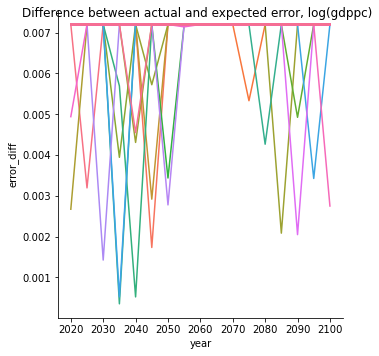

In [8]:
subset = error_diff.loc[error_diff.simulation == 1]
subset = subset.loc[~subset.iso.isin(
    ['ABW', 'AFG', 'AGO', 'ALB', 'ARE', 'MAC', 'MMR', 'MNE', 'NCL','PYF', 'QAT', 'PSE', 'TWN'])]

g = sns.relplot(
    data=subset,
    x='year',
    y='error_diff',
    kind='line',
    hue='iso',
)

g.fig.suptitle("Difference between actual and expected error, log(gdppc)")
g._legend.remove()

plt.savefig(f'/mnt/CIL_integration/rff_diagnostics/v{v}/error_difference_sim1.png', bbox_to_inches='tight', dpi=300)

In [ ]:
subset = error_diff.loc[error_diff.iso.isin(['USA', 'CHN', 'BRA', 'IND', 'CAN', 'NGA', 'EGY', 'FRA', 'ZAF'])]

g = sns.relplot(
    data=subset,
    x='year',
    y='error_diff',
    kind='line',
    hue='simulation',
    col='iso',
    col_wrap=3
)

g.fig.suptitle("Difference between actual and expected error, log(gdppc)")
g._legend.remove()

plt.savefig(f'/mnt/CIL_integration/rff_diagnostics/v{v}/error_difference_first2000.png', bbox_to_inches='tight', dpi=300)